In [1]:
import torch 
import os
import numpy as np
import scipy as sp
import scipy.io as sio
# import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
from net.base_net import CuiNet,DeepSpectraCNN,ResNet18_1D,ViT_1D,FullyConvNet
from utils.testing import test                      # ligne rajoutée
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test 
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

# JC pour importer les fichiers tabulés
import numpy as np
import pandas as pd
import sys 


2025-01-17 09:08:04.862352: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# un lien relatif permet de placer le répertoire Deep-chemometrics-jcb n'importe où sur le disque
local_path=os.getcwd()

# la première ligne commentée est celle valable pour galaxy

#X_train=pd.read_csv("${Xdata.file_name}", sep="\t", header=0)
local_path_xcal=local_path+'/data/rmn_196/xtrain_rmn.tab'
Xcal=pd.read_csv(local_path_xcal, sep="\t", header=0)
Xcal.drop(Xcal.columns[0],axis=1,inplace=True)

#Y_train=pd.read_csv("${Ydata.file_name}", sep="\t", header=0)
local_path_ycal=local_path+'/data/rmn_196/ytrain_rmn.tab'
Ycal=pd.read_csv(local_path_ycal, sep="\t", header=0)

#X_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_xtest=local_path+'/data/rmn_196/xtest_rmn.tab'
Xtest=pd.read_csv(local_path_xtest, sep="\t", header=0)
Xtest.drop(Xtest.columns[0],axis=1,inplace=True)

#Y_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_ytest=local_path+'/data/rmn_196/ytest_rmn.tab'
Ytest=pd.read_csv(local_path_ytest, sep="\t", header=0)

## partie à décommenter pour galaxy
#Y_column=${Ycolumn}-1
#Y_column_val=${Ycolumn_val}-1   ## debut a 0

Ycal=Ycal.iloc[:,1:2]
Ytest=Ytest.iloc[:,1:2]

In [3]:
print("X and Y training set")
print(Ycal.shape)
print(Xcal.shape)
print("convert to one hot encoding")
Ycal = np.squeeze(np.eye(2)[Ycal])
print(Ycal.shape)

X and Y training set
(147, 1)
(147, 2101)
convert to one hot encoding
(147, 2)


In [4]:
print("X and Y testing set")
print(Ytest.shape)
print("convert to one hot encoding")
Ytest = np.squeeze(np.eye(2)[Ytest])
print(Xtest.shape)
print(Ytest.shape)

X and Y testing set
(49, 1)
convert to one hot encoding
(49, 2101)
(49, 2)


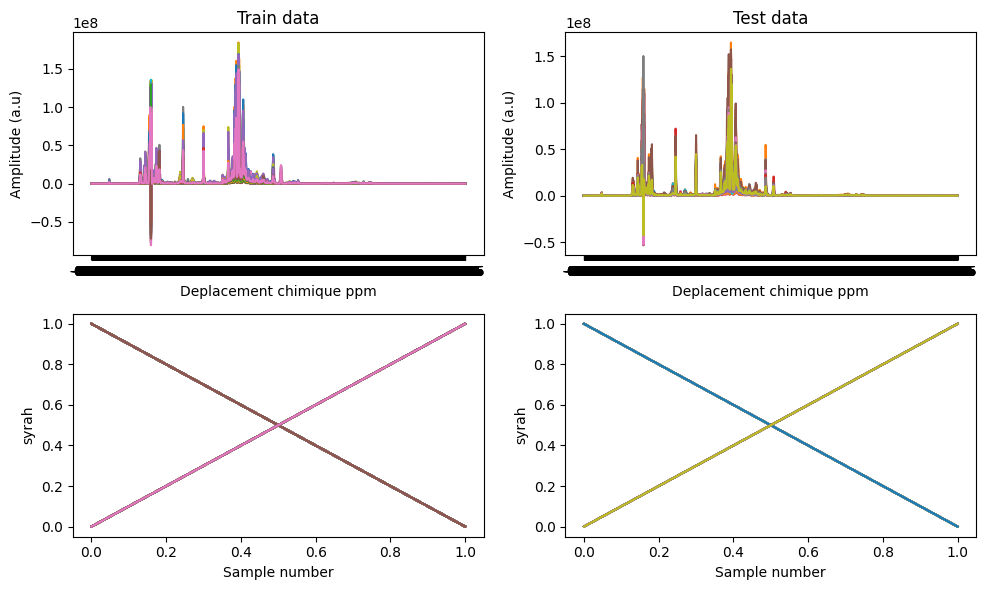

In [5]:
plt.figure(figsize=(10,6))

plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(223)
# plt.plot(data['DM_cal'])
plt.plot(Ycal.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.subplot(224)
# plt.plot(data['DM_test'])
plt.plot(Ytest.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.tight_layout()
plt.show()

In [6]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
# x_scale=data['wave'].astype(np.float32).reshape(-1,1)               data ne sert pas car fichier pas matlab

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
# print('wavelengths number = {}'.format(np.shape(x_scale)))          pas data -> pas xscale

Data set dimensions ----------------------------
Full Train set dims X Y = (147, 2101)	(147, 2)
Calibration set dims X Y = (117, 2101)	(117, 2)
val set dims X Y = (30, 2101)	(30, 2)
Test set dims X Y = (49, 2101)	(49, 2)


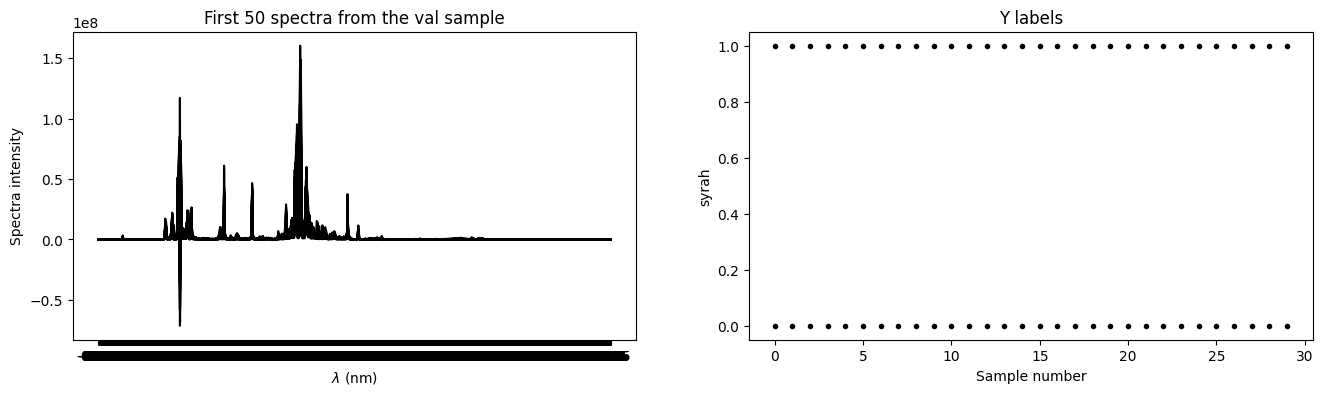

In [7]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
# plt.plot(x_val[:50,:].T,'k')
plt.plot(x_val.T,'k')           # .T est la transposée

plt.title('First 50 spectra from the val sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('syrah')
plt.show()

In [8]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

# JC conversion en np.array
x_cal=np.array(x_cal)
y_cal=np.array(y_cal)
x_val=np.array(x_val)
y_val=np.array(y_val)
Xtest=np.array(Xtest)
Ytest=np.array(Ytest)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=1024, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=1024, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=1024, shuffle=True)


/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/data/rmn_196//models/_cuinet_rmn_14jan25_v1/_cuinet_rmn_14jan25_v1
CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=2097, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)


/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mean = nn.Parameter(torch.tensor(mean).float(),requires_grad=False)
/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.std = nn.Parameter(torch.tensor(std).float(),requires_grad=False)


Epoch 1/1000 | Train Losses: y 0: 14.4299 | Validation Losses: y 0: 8.1842 | Metrics: F1 Score: 0.6000
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/data/rmn_196//models/_cuinet_rmn_14jan25_v1/_cuinet_rmn_14jan25_v1_best.pth
Epoch 2/1000 | Train Losses: y 0: 9.7613 | Validation Losses: y 0: 8.9998 | Metrics: F1 Score: 0.6667
Epoch 3/1000 | Train Losses: y 0: 10.9609 | Validation Losses: y 0: 11.0818 | Metrics: F1 Score: 0.5667
Epoch 4/1000 | Train Losses: y 0: 6.4388 | Validation Losses: y 0: 9.4104 | Metrics: F1 Score: 0.6333
Epoch 5/1000 | Train Losses: y 0: 7.8556 | Validation Losses: y 0: 8.7379 | Metrics: F1 Score: 0.6333
Epoch 6/1000 | Train Losses: y 0: 2.8439 | Validation Losses: y 0: 8.2103 | Metrics: F1 Score: 0.6333
Epoch 7/1000 | Train Losses: y 0: 4.7508 | Validation Losses: y 0: 7.0451 | Metrics: F1 Score: 0.6667
Model saved at epoch 7 to /home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/data/rmn_196//models/_cuinet_rmn_14jan25_v1

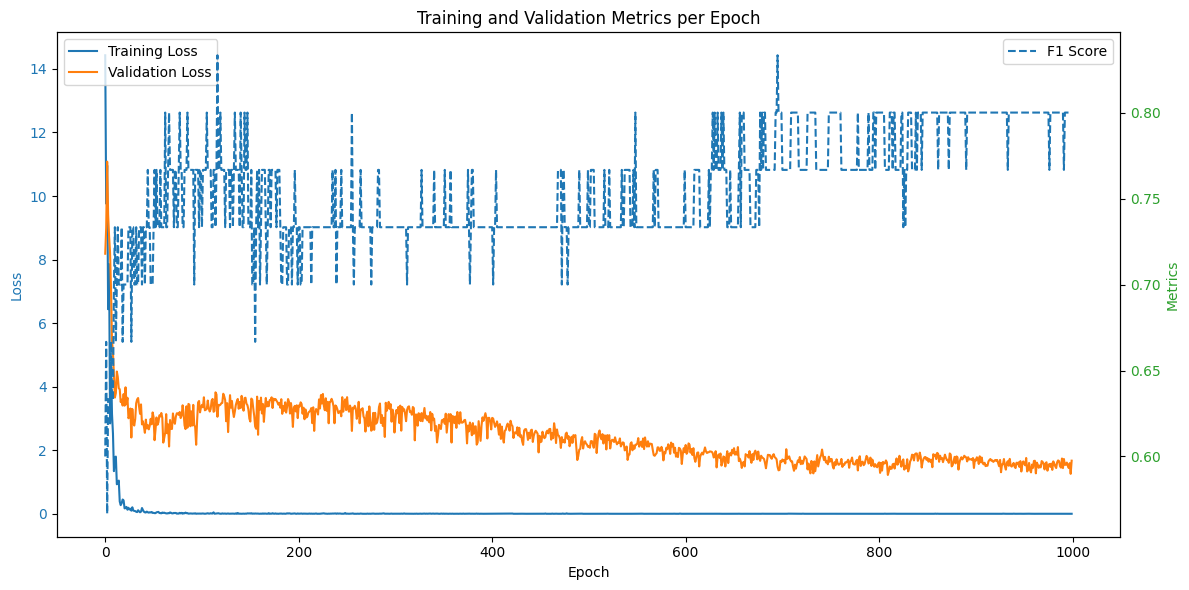

In [9]:
# define model parameters 

model_name ="_cuinet_rmn_14jan25_v1"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10

# repertoire de sauvegarde 
# 14jan25: Deep-Chemometrics-main/data/dataset/Mango/Mango/models/_CuiNet_Mango
# save_path = os.path.dirname(local_path) + f'/models/{model_name}/' + model_name
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# CuiNet est un modèle pré-défini 
model = CuiNet(spec_dims, mean = mean,std = std, out_dims=2)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)
#CuiNet(
#  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
#  (fc1): Linear(in_features=614, out_features=36, bias=True)
#  (fc2): Linear(in_features=36, out_features=18, bias=True)
#  (fc3): Linear(in_features=18, out_features=12, bias=True)
#  (out): Linear(in_features=12, out_features=1, bias=True)
#)

train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)

In [10]:

test(model,final_path,test_loader,classification=True)

# => AssertionError: Torch not compiled with CUDA enabled


(49, 2)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       0.89      0.94      0.92        18

    accuracy                           0.94        49
   macro avg       0.93      0.94      0.93        49
weighted avg       0.94      0.94      0.94        49

[[29  2]
 [ 1 17]]


DeepSpectraCNN(
  (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(3,), padding=(3,))
  (inception2): InceptionModule(
    (branch1): ConvBlock1D(
      (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
      (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch2): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ConvBlock1D(
        (conv1d): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (branch3): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d)

/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:213: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mean = nn.Parameter(torch.tensor(mean).float(),requires_grad=False)
/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.std = nn.Parameter(torch.tensor(std).float(),requires_grad=False)


Epoch 13/1000 | Train Losses: y 0: 0.4997 | Validation Losses: y 0: 0.6679 | Metrics: F1 Score: 0.7000
Epoch 14/1000 | Train Losses: y 0: 0.5041 | Validation Losses: y 0: 0.6603 | Metrics: F1 Score: 0.7000
Epoch 15/1000 | Train Losses: y 0: 0.4735 | Validation Losses: y 0: 0.6461 | Metrics: F1 Score: 0.6667
Epoch 16/1000 | Train Losses: y 0: 0.4294 | Validation Losses: y 0: 0.6343 | Metrics: F1 Score: 0.6667
Model saved at epoch 16 to /home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/data/rmn_196//models/_DeepSpectra_Mango_/_DeepSpectra_Mango__best.pth
Epoch 17/1000 | Train Losses: y 0: 0.4735 | Validation Losses: y 0: 0.6260 | Metrics: F1 Score: 0.7000
Model saved at epoch 17 to /home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/data/rmn_196//models/_DeepSpectra_Mango_/_DeepSpectra_Mango__best.pth
Epoch 18/1000 | Train Losses: y 0: 0.4220 | Validation Losses: y 0: 0.6173 | Metrics: F1 Score: 0.6667
Model saved at epoch 18 to /home/metz/deepchemometrics/Aioly_jcb/Deep-Chemom

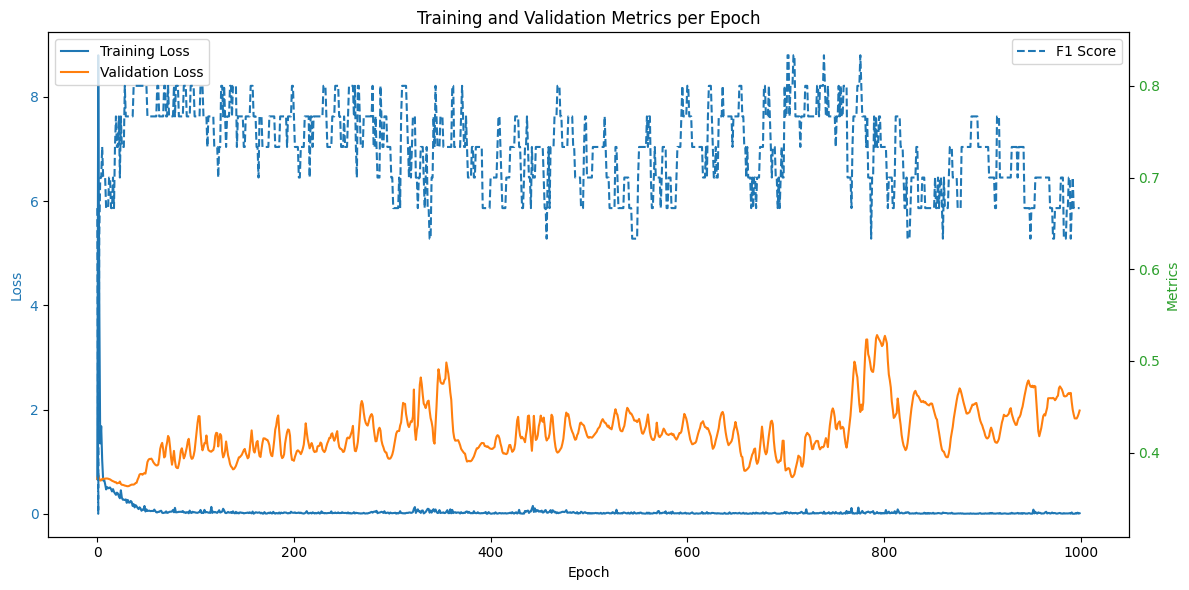

In [11]:
model_name ="_DeepSpectra_Mango_"  
LR = 0.01
num_epochs = 1000
save_interval = 10
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name


model = DeepSpectraCNN(spec_dims, mean = mean,std = std, out_dims=2)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')
print(model)

train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)


In [12]:
test(model,final_path,test_loader,classification=True)

(49, 2)
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        31
           1       0.86      0.67      0.75        18

    accuracy                           0.84        49
   macro avg       0.84      0.80      0.81        49
weighted avg       0.84      0.84      0.83        49

[[29  2]
 [ 6 12]]


In [13]:

model_name ="_ResNET18_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
save_path = os.path.dirname(local_path) + f'/models/{model_name}/' + model_name

model = ResNet18_1D(mean = mean,std = std, out_dims=2)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
print(model)

# lent à calculer! 
train_losses, val_losses, metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)

ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, 

/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mean = nn.Parameter(torch.tensor(mean).float(), requires_grad=False)
/home/metz/deepchemometrics/Aioly_jcb/Deep-Chemometrics/net/base_net.py:322: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.std = nn.Parameter(torch.tensor(std).float(), requires_grad=False)


Epoch 8/1000 | Train Losses: y 0: 0.6062 | Validation Losses: y 0: 0.6307 | Metrics: F1 Score: 0.6667
Model saved at epoch 8 to /home/metz/deepchemometrics/Aioly_jcb/models/_ResNET18_Mango_/_ResNET18_Mango__best.pth
Epoch 9/1000 | Train Losses: y 0: 0.6059 | Validation Losses: y 0: 0.6333 | Metrics: F1 Score: 0.6667
Epoch 10/1000 | Train Losses: y 0: 0.5792 | Validation Losses: y 0: 0.6335 | Metrics: F1 Score: 0.7000
Epoch 11/1000 | Train Losses: y 0: 0.5599 | Validation Losses: y 0: 0.6535 | Metrics: F1 Score: 0.7000
Epoch 12/1000 | Train Losses: y 0: 0.5601 | Validation Losses: y 0: 0.7297 | Metrics: F1 Score: 0.6667
Epoch 13/1000 | Train Losses: y 0: 0.5663 | Validation Losses: y 0: 0.8260 | Metrics: F1 Score: 0.6000
Epoch 14/1000 | Train Losses: y 0: 0.5551 | Validation Losses: y 0: 0.8608 | Metrics: F1 Score: 0.6000
Epoch 15/1000 | Train Losses: y 0: 0.5540 | Validation Losses: y 0: 0.8558 | Metrics: F1 Score: 0.6000
Epoch 16/1000 | Train Losses: y 0: 0.5692 | Validation Losses: y

KeyboardInterrupt: 

In [ ]:
test(model, final_path, test_loader)

In [ ]:

model_name ="_ViT_1D_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
save_path = os.path.dirname(local_path) + f'/models/{model_name}/' + model_name

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 10, dim_embed = 64, trans_layers = 8, heads = 8, mlp_dim = 64, out_dims =2, dropout=0.5)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)

print(model)

# très lent!
train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)

In [ ]:
test(model, final_path, test_loader)

In [ ]:
model_name ="_FullyConvNet_OSSL_"
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
save_path = os.path.dirname(local_path) + f'/models/{model_name}/' + model_name

model = FullyConvNet(spec_dims, mean = mean,std = std,out_dims=2)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)


In [ ]:
test(model, final_path, test_loader)